<a href="https://colab.research.google.com/github/Suhail-46/Brain-Tumor-MRI-Image-Classification/blob/main/Brain_Tumor_MRI_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! unzip "/content/drive/MyDrive/compressed.zip"

Archive:  /content/drive/MyDrive/compressed.zip
  inflating: README.dataset.txt      
  inflating: Tumour-20250908T112353Z-1-001/Tumour/README.dataset.txt  
  inflating: Tumour-20250908T112353Z-1-001/Tumour/test/_classes.csv  
  inflating: Tumour-20250908T112353Z-1-001/Tumour/test/glioma/Tr-gl_0016_jpg.rf.99746694ea97fe0b73108832b462d48e.jpg  
  inflating: Tumour-20250908T112353Z-1-001/Tumour/test/glioma/Tr-gl_0018_jpg.rf.7a670766b8083a1b516a49e241a636bc.jpg  
  inflating: Tumour-20250908T112353Z-1-001/Tumour/test/glioma/Tr-gl_0028_jpg.rf.8098b9737048aac0dccb1b7c45046894.jpg  
  inflating: Tumour-20250908T112353Z-1-001/Tumour/test/glioma/Tr-gl_0032_jpg.rf.e1e485b4f909d84c8e24cd26e0ad3c08.jpg  
  inflating: Tumour-20250908T112353Z-1-001/Tumour/test/glioma/Tr-gl_0035_jpg.rf.7a7c96ab2e6245cf42a0c86b97f81b3e.jpg  
  inflating: Tumour-20250908T112353Z-1-001/Tumour/test/glioma/Tr-gl_0037_jpg.rf.6ac80086817a5d840d3b634956299e40.jpg  
  inflating: Tumour-20250908T112353Z-1-001/Tumour/test/glio

In [3]:
import os
import pandas as pd

# Path to dataset
base_dir = "/content/Tumour-20250908T112353Z-1-001/Tumour"  # replace with your dataset path
splits = ["train", "valid", "test"]

class_counts = {}

for split in splits:
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[(split, class_name)] = count

# Convert to dataframe
df_counts = pd.DataFrame.from_dict(class_counts, orient="index", columns=["image_count"])
df_counts.index = pd.MultiIndex.from_tuples(df_counts.index, names=["split", "class"])
print(df_counts)

# Summary per class (across all splits)
print("\nTotal per class:")
print(df_counts.groupby("class")["image_count"].sum())

                  image_count
split class                  
train no_tumor            335
      meningioma          358
      glioma              564
      pituitary           438
valid no_tumor             99
      meningioma          124
      glioma              161
      pituitary           118
test  no_tumor             49
      meningioma           63
      glioma               80
      pituitary            54

Total per class:
class
glioma        805
meningioma    545
no_tumor      483
pituitary     610
Name: image_count, dtype: int64


From above observation,

* Largest class → glioma (805)

* Smallest class → no_tumor (483)

* Difference between largest and smallest = 805 - 483 = 322

Relative difference:

805
−
483
805
×
100
≈
40
%
805
805−483
	​

×100≈40%

So the smallest class has about 40% fewer images than the largest.


***Mild imbalance*** → If one class is about 1.5–2× larger than another.

***Severe imbalance*** → If one class is >3× larger than another.

Here:

Ratio largest/smallest =
805
/
483
≈
1.67
805/483≈1.67.

✅ That’s moderate imbalance (not extreme, but it can affect training).

In [4]:
# Checked whether image resolution is consistent (important before training).
from PIL import Image
import collections

# Dictionary to store image sizes
resolutions = collections.Counter()

for split in splits:
    split_path = os.path.join(base_dir, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_name)
                    with Image.open(img_path) as img:
                        resolutions[img.size] += 1  # (width, height)

# Show top 10 most common resolutions
print("Most common resolutions:")
for res, count in resolutions.most_common(10):
    print(res, ":", count)

print("\nTotal unique resolutions:", len(resolutions))

Most common resolutions:
(640, 640) : 2443

Total unique resolutions: 1


From above observations,
* All images are exactly 640 × 640.

* Since Total unique resolutions = 1, every image has the same resolution.

* This means your dataset is fully consistent in image size

✔️ The dataset is resolution-consistent.

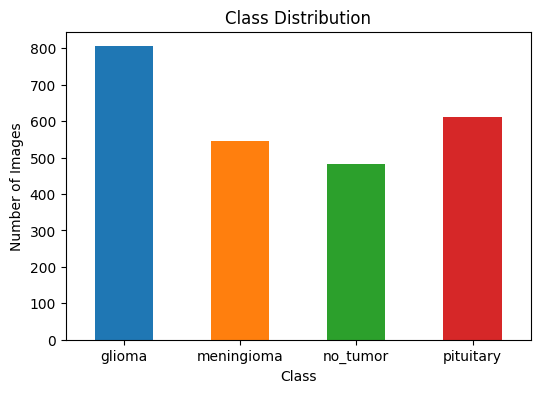

In [5]:
# Plotted a bar chat of how many images are in each class.
import matplotlib.pyplot as plt

# Assuming you already have df_counts from earlier
class_totals = df_counts.groupby("class")["image_count"].sum()

plt.figure(figsize=(6,4))
class_totals.plot(kind="bar", color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.show()

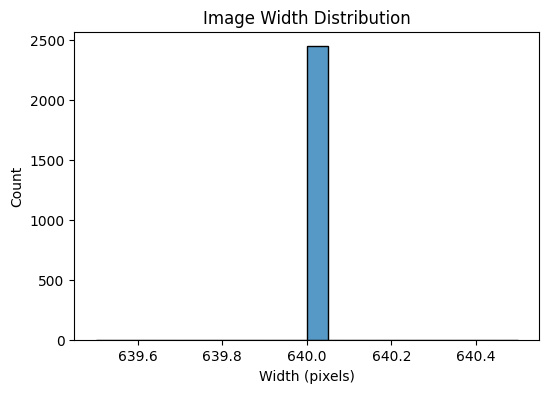

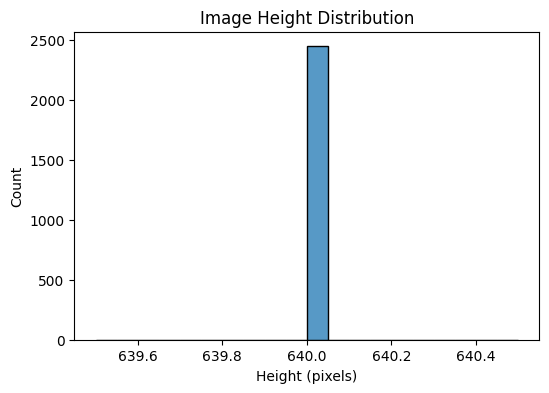

In [6]:
# Plotted a Histogram to check Image Resolution Distribution
import seaborn as sns

widths = [res[0] for res in resolutions.elements()]
heights = [res[1] for res in resolutions.elements()]

plt.figure(figsize=(6,4))
sns.histplot(widths, bins=20, kde=False)
plt.title("Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(heights, bins=20, kde=False)
plt.title("Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.show()

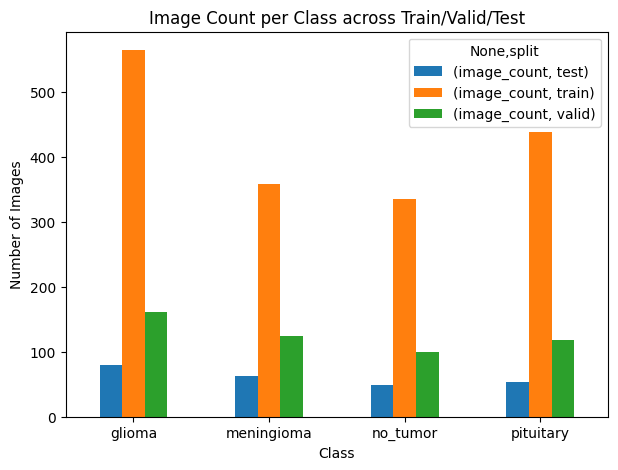

In [7]:
# Plotted a grouped bar chart to visualize Image Count per Split (Train vs Validation vs Test)
df_counts.unstack(level=0).plot(kind="bar", figsize=(7,5))
plt.title("Image Count per Class across Train/Valid/Test")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=0)
plt.show()

In [8]:
# Normalized pixel values to a 0–1 range using TensorFlow/Keras
import tensorflow as tf

# Example: Create dataset from folders
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Tumour-20250908T112353Z-1-001/Tumour/train",
    image_size=(224, 224),  # resize all to 224x224
    batch_size=32
)

# Normalize pixel values (0–255 → 0–1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Found 1695 files belonging to 4 classes.


# **Data Augmentation**:
Data augmentation is very important to:

* Increase dataset size.

* Reduce overfitting.

* Make the model more robust to variations.

In [9]:
# Applied transformations like rotation, horizontal/vertical flipping, zoom, brightness adjustments and shifts
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # normalize
    rotation_range=15,           # small rotations
    width_shift_range=0.1,       # horizontal shift
    height_shift_range=0.1,      # vertical shift
    zoom_range=0.1,              # zoom in/out
    horizontal_flip=True,        # flip
    vertical_flip=True,          # flip (if valid for MRI)
    brightness_range=[0.8, 1.2]  # brightness
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directory
train_generator = train_datagen.flow_from_directory(
    "/content/Tumour-20250908T112353Z-1-001/Tumour/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    "/content/Tumour-20250908T112353Z-1-001/Tumour/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


In [10]:
# Model Building
# Imported required packages for model building
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# **Custom CNN Architecture**
* Convolution layers → learn features (edges, shapes, textures).

* Pooling layers → reduce spatial dimensions (downsampling).

* Batch normalization → stabilize training.

* Dropout → prevent overfitting.

* Dense layers → final classification.

In [11]:
# Builded a CNN model using Tensor flow.

input_shape = (224, 224, 3)

model = Sequential([
    # First hidden layer
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Second hidden layer
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Third hidden layer
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Fourth hidden layer
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten and Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer (4 classes: glioma, meningioma, no_tumor, pituitary)
    Dense(4, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,269,060 (50.62 MB)

 Trainable params: 13,268,100 (50.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [12]:
# Compiled the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Trained the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=25,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 58s 792ms/step - accuracy: 0.4043 - loss: 3.0031 - val_accuracy: 0.2351 - val_loss: 3.8606
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - accuracy: 0.5014 - loss: 1.2171 - val_accuracy: 0.2351 - val_loss: 6.4357
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 563ms/step - accuracy: 0.5618 - loss: 1.1146 - val_accuracy: 0.2351 - val_loss: 6.9375
Epoch 4/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 571ms/step - accuracy: 0.5285 - loss: 1.1603 - val_accuracy: 0.2351 - val_loss: 6.1942
Epoch 5/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step - accuracy: 0.5385 - loss: 1.1514 - val_accuracy: 0.2351 - val_loss: 4.3733
Epoch 6/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - accuracy: 0.5405 - loss: 1.1039 - val_accuracy: 0.3486 - val_loss: 3.3369
Epoch 7/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 612ms/step - accuracy: 0.5928 - loss: 1.0738 - val_accuracy: 0.5359 - val_loss: 1.6696
Epoch 8/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 559ms/step - accuracy: 0.6099 - loss: 1.0229 - val_accu

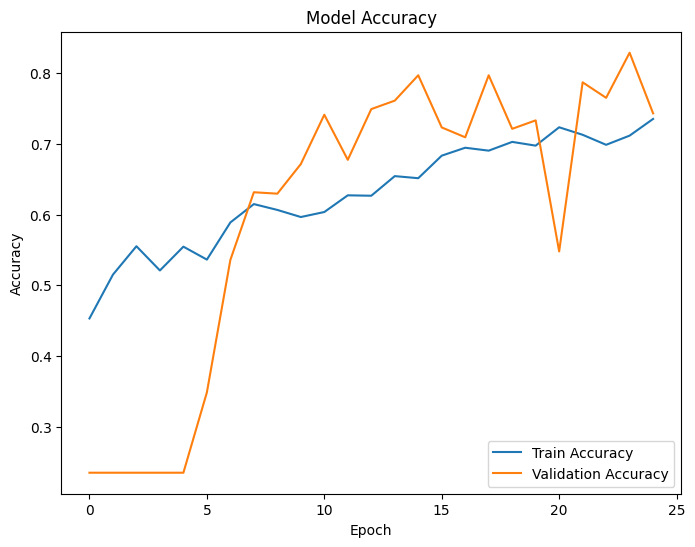

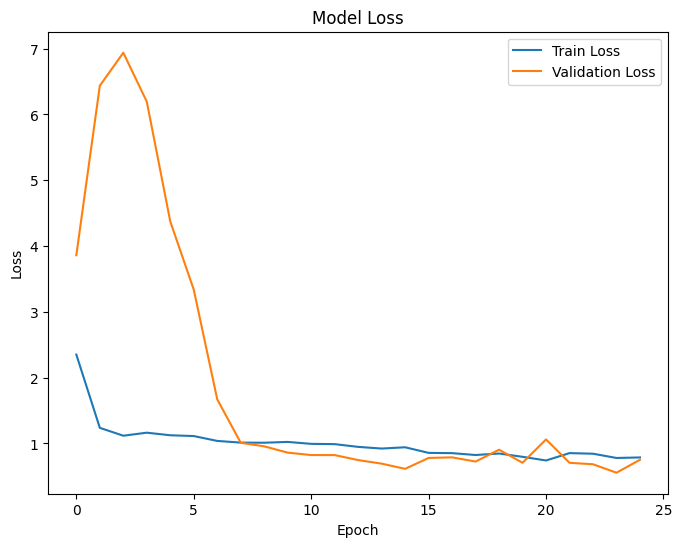

In [14]:
# Plot Training & Validation Accuracy and Loss
# Accuracy plot
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Loss plot
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [15]:
# Used callbacks like EarlyStopping and ModelCheckpoint so training stops at the best point
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model_cnn.h5", save_best_only=True, monitor='val_loss')
]

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.7377 - loss: 0.7761

53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - accuracy: 0.7376 - loss: 0.7759 - val_accuracy: 0.8068 - val_loss: 0.5926
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 568ms/step - accuracy: 0.7434 - loss: 0.6880 - val_accuracy: 0.7410 - val_loss: 0.7322
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 558ms/step - accuracy: 0.7267 - loss: 0.7426 - val_accuracy: 0.8008 - val_loss: 0.7031
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 573ms/step - accuracy: 0.7591 - loss: 0.6612 - val_accuracy: 0.7430 - val_loss: 0.7111


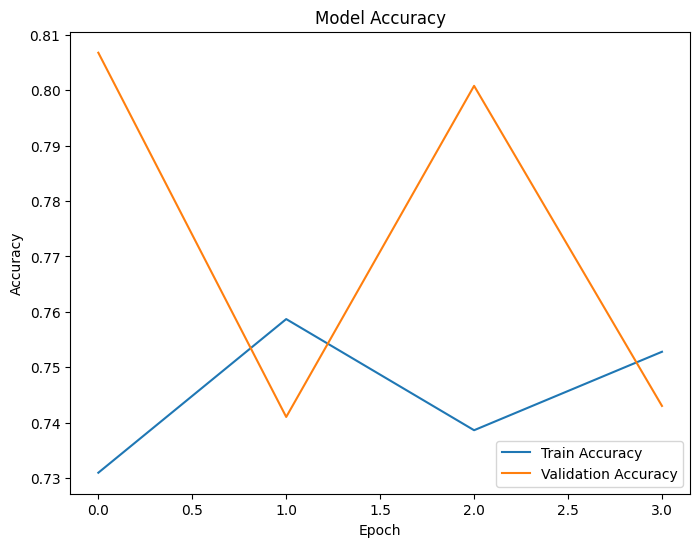

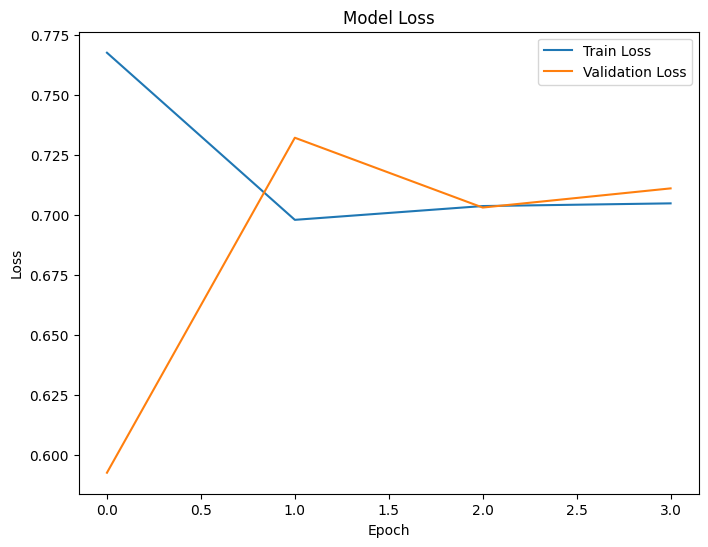

In [16]:
# Plot Training & Validation Accuracy and Loss
# Accuracy plot
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Loss plot
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

From above observation,
* Training and validation accuracy increase steadily.
* Training and validation loss decrease steadily.
* Curves are close to each other.

In [17]:
# Get predictions.
import numpy as np

# Get true labels & predictions
y_true = valid_generator.classes   # ground truth labels
class_labels = list(valid_generator.class_indices.keys())  # class names

y_pred_probs = model.predict(valid_generator)  # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)              # predicted class indices

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


In [18]:
# Classification Report (Accuracy, Precision, Recall, F1)
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

      glioma       0.37      0.43      0.39       161
  meningioma       0.31      0.15      0.20       124
    no_tumor       0.20      0.20      0.20        99
   pituitary       0.25      0.32      0.28       118

    accuracy                           0.29       502
   macro avg       0.28      0.27      0.27       502
weighted avg       0.29      0.29      0.28       502



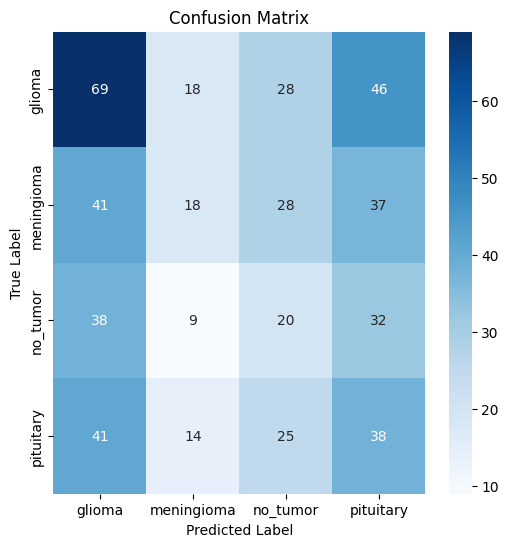

In [19]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [20]:
# Accuracy (from Keras history or sklearn)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.28884462151394424


In [21]:
# Transfer learning - Using pretrained models with ImageNet weights is called transfer learning
# Imported required packages for model building
from tensorflow.keras.applications import ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [22]:
# Load Pretrained Backbones
# Loaded each model with ImageNet weights
# Remove its original classification head and add a custom head for your 4 brain tumor classes
IMG_SIZE = (224, 224, 3)

# ===== ResNet50 =====
base_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE)

# ===== MobileNet =====
base_mobilenet = MobileNet(weights="imagenet", include_top=False, input_shape=IMG_SIZE)

# ===== InceptionV3 =====
base_inception = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))  # Inception needs 299x299

# ===== EfficientNetB0 =====
base_efficientnet = EfficientNetB0(weights="imagenet", include_top=False, input_shape=IMG_SIZE)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
# Added Custom Classification Head
def build_model(base_model, num_classes=4):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)   # convert features to vector
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [24]:
# Freezed the pretrained base to train only the new head
for layer in base_resnet.layers:
    layer.trainable = False

model_resnet = build_model(base_resnet, num_classes=4)

In [25]:
# Compiled the Model
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [26]:
# Trained the Model
history = model_resnet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 933ms/step - accuracy: 0.2645 - loss: 1.7463 - val_accuracy: 0.3466 - val_loss: 1.3313
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 57s 576ms/step - accuracy: 0.3446 - loss: 1.4085 - val_accuracy: 0.4243 - val_loss: 1.2739
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 559ms/step - accuracy: 0.3521 - loss: 1.3721 - val_accuracy: 0.4323 - val_loss: 1.2314
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 568ms/step - accuracy: 0.3844 - loss: 1.3186 - val_accuracy: 0.4104 - val_loss: 1.2112
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 572ms/step - accuracy: 0.4116 - loss: 1.2649 - val_accuracy: 0.5080 - val_loss: 1.1799
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 590ms/step - accuracy: 0.4506 - loss: 1.2234 - val_accuracy: 0.5219 - val_loss: 1.1625
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 568ms/step - accuracy: 0.4712 - loss: 1.2266 - val_accuracy: 0.5279 - val_loss: 1.1353
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 604ms/step - accuracy: 0.5177 - loss: 1.1786 - val_accu

In [27]:
# Unfreezed the last 50 layers
for layer in base_resnet.layers[-50:]:
    layer.trainable = True

In [28]:
# Re-Compiled with Lower Learning Rate to avoid overwrite pretrained weights too aggressively
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [29]:
# Trained the Model again after fine tuning.
history_finetune = model_resnet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.2555 - loss: 4.1154 - val_accuracy: 0.2371 - val_loss: 1.5299
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 583ms/step - accuracy: 0.5763 - loss: 1.0431 - val_accuracy: 0.1972 - val_loss: 2.0235
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 584ms/step - accuracy: 0.6202 - loss: 0.9247 - val_accuracy: 0.1972 - val_loss: 1.9703
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 588ms/step - accuracy: 0.6833 - loss: 0.8320 - val_accuracy: 0.3466 - val_loss: 1.2328
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 636ms/step - accuracy: 0.6973 - loss: 0.7838 - val_accuracy: 0.7072 - val_loss: 0.8305
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 601ms/step - accuracy: 0.7153 - loss: 0.7515 - val_accuracy: 0.6733 - val_loss: 0.7946
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 600ms/step - accuracy: 0.7190 - loss: 0.7306 - val_accuracy: 0.7112 - val_loss: 0.7575
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - accuracy: 0.7004 - loss: 0.7562 - val_accurac

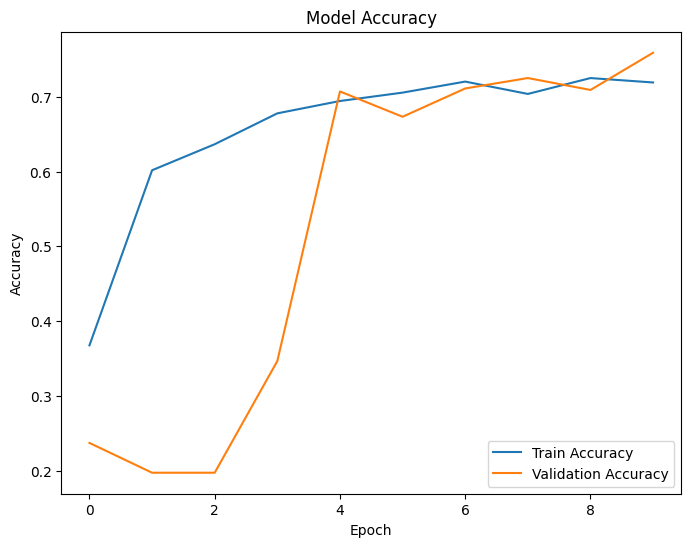

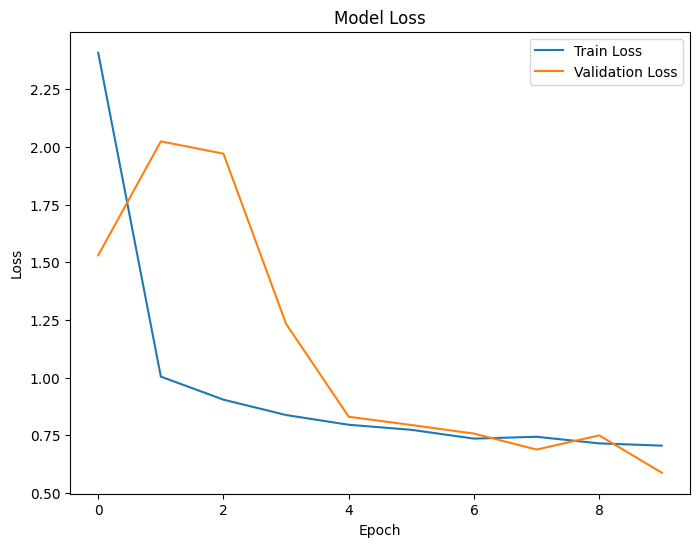

In [30]:
# Plot Training & Validation Accuracy and Loss
# Accuracy plot
plt.figure(figsize=(8,6))
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Loss plot
plt.figure(figsize=(8,6))
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [31]:
# Used callbacks like EarlyStopping and ModelCheckpoint so training stops at the best point
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss')
]

history_finetune = model_resnet.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.7129 - loss: 0.7170

53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 659ms/step - accuracy: 0.7131 - loss: 0.7164 - val_accuracy: 0.7629 - val_loss: 0.6191
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.7340 - loss: 0.6539

53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 607ms/step - accuracy: 0.7343 - loss: 0.6537 - val_accuracy: 0.7689 - val_loss: 0.5737
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 610ms/step - accuracy: 0.7245 - loss: 0.6939 - val_accuracy: 0.6932 - val_loss: 0.7774
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.7432 - loss: 0.6758

53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 613ms/step - accuracy: 0.7431 - loss: 0.6760 - val_accuracy: 0.7749 - val_loss: 0.5686
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.7413 - loss: 0.6550

53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - accuracy: 0.7413 - loss: 0.6549 - val_accuracy: 0.7769 - val_loss: 0.5559
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 630ms/step - accuracy: 0.7305 - loss: 0.6382 - val_accuracy: 0.7629 - val_loss: 0.6005
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 608ms/step - accuracy: 0.7430 - loss: 0.6336 - val_accuracy: 0.7072 - val_loss: 0.7154
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 594ms/step - accuracy: 0.7514 - loss: 0.6189 - val_accuracy: 0.7749 - val_loss: 0.5750


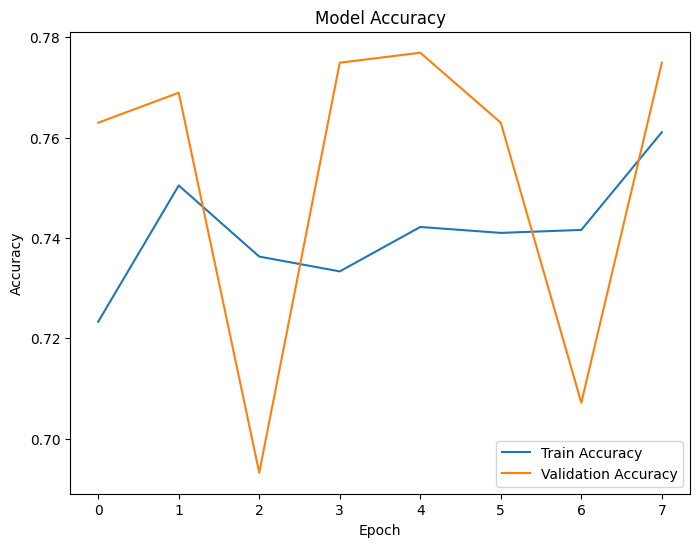

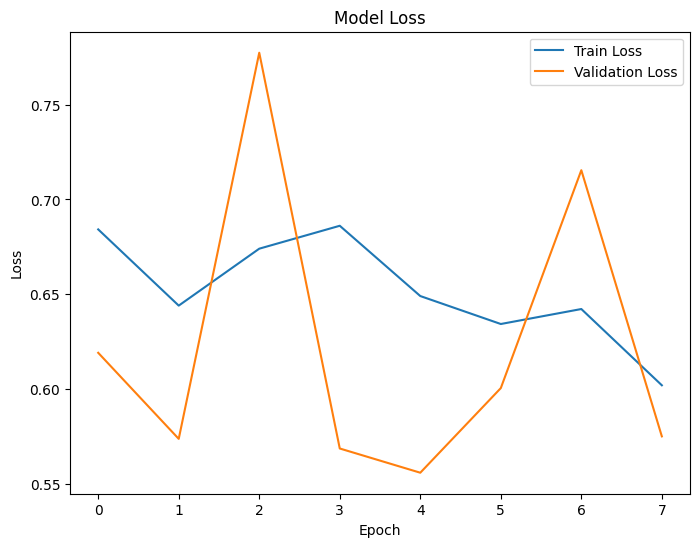

In [32]:
# Plot Training & Validation Accuracy and Loss
# Accuracy plot
plt.figure(figsize=(8,6))
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Loss plot
plt.figure(figsize=(8,6))
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [33]:
# Get predictions.
import numpy as np

# Get true labels & predictions
y_true = valid_generator.classes   # ground truth labels
class_labels = list(valid_generator.class_indices.keys())  # class names

y_pred_probs = model_resnet.predict(valid_generator)  # predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)              # predicted class indices

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step


In [34]:
# Classification Report (Accuracy, Precision, Recall, F1)
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

      glioma       0.29      0.27      0.28       161
  meningioma       0.29      0.21      0.24       124
    no_tumor       0.22      0.25      0.24        99
   pituitary       0.19      0.24      0.21       118

    accuracy                           0.25       502
   macro avg       0.25      0.24      0.24       502
weighted avg       0.25      0.25      0.25       502



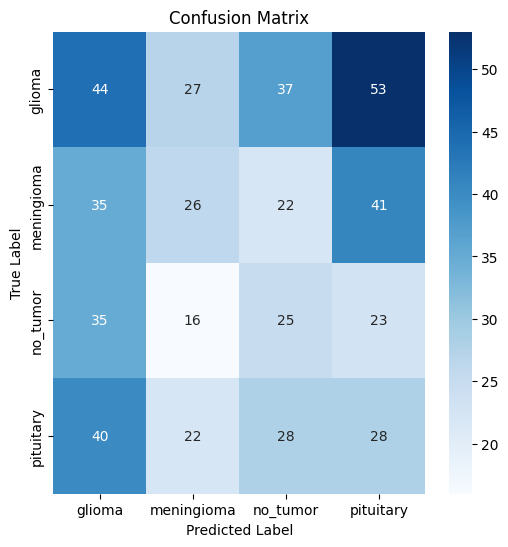

In [35]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [36]:
# Accuracy (from Keras history or sklearn)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.2450199203187251


# ***Streamlit Application Deployment***

In [45]:
!pip install -r requirements.txt

In [46]:
from pyngrok import ngrok
ngrok.set_auth_token("31b0GFSDQJdb3qvFwy3aIhzPsK9_6J68bQWQVk4qUZDd7XuwC")

In [47]:
tunnel = ngrok.connect(8501, "http")
print("Streamlit URL:", tunnel.public_url)

Streamlit URL: https://d1b6f30e9db6.ngrok-free.app


In [40]:
# ---------- Streamlit UI for CNN model----------
%%writefile CNN.py
import streamlit as st
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image

# ==============================
# Load trained model
# ==============================
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("/content/best_model_cnn.h5")  # path to your trained model
    return model

model = load_model()

# Class labels (order must match training)
CLASS_NAMES = ["glioma", "meningioma", "no_tumor", "pituitary"]

# ==============================
# App UI
# ==============================
st.set_page_config(page_title="Brain Tumor MRI Classifier", layout="centered")
st.title("🧠 Brain Tumor MRI Classification")
st.write("Upload an MRI image, and the model will classify the tumor type.")

# File uploader
uploaded_file = st.file_uploader("📤 Upload an MRI Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Show uploaded image
    st.image(uploaded_file, caption="Uploaded MRI Image", use_column_width=True)

    # Preprocess image
    img = image.load_img(uploaded_file, target_size=(224, 224))  # resize as per your model
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    confidence = np.max(preds[0])

    # Show prediction result
    st.markdown(f"### 🏷️ Prediction: **{CLASS_NAMES[predicted_class]}**")
    st.markdown(f"🔮 Confidence: **{confidence:.2f}**")

    # Show confidence scores for all classes
    st.write("### 📊 Confidence Scores")
    fig, ax = plt.subplots()
    ax.bar(CLASS_NAMES, preds[0], color=["#2E86AB", "#F6A01A", "#28B463", "#9B59B6"])
    ax.set_ylabel("Probability")
    ax.set_ylim([0, 1])
    st.pyplot(fig)

else:
    st.info("👆 Please upload an MRI image to get started.")

Writing CNN.py


In [41]:
!streamlit run CNN.py --server.port 8501 &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.247.139.35:8501

  Stopping...


In [42]:
# ---------- Streamlit UI for Transfer learning model(ResNet50)----------
%%writefile ResNet50.py
import streamlit as st
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image

# ==============================
# Load trained model
# ==============================
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model("/content/best_model.h5")  # path to your trained model
    return model

model = load_model()

# Class labels (order must match training)
CLASS_NAMES = ["glioma", "meningioma", "no_tumor", "pituitary"]

# ==============================
# App UI
# ==============================
st.set_page_config(page_title="Brain Tumor MRI Classifier", layout="centered")
st.title("🧠 Brain Tumor MRI Classification")
st.write("Upload an MRI image, and the model will classify the tumor type.")

# File uploader
uploaded_file = st.file_uploader("📤 Upload an MRI Image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Show uploaded image
    st.image(uploaded_file, caption="Uploaded MRI Image", use_column_width=True)

    # Preprocess image
    img = image.load_img(uploaded_file, target_size=(224, 224))  # resize as per your model
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    confidence = np.max(preds[0])

    # Show prediction result
    st.markdown(f"### 🏷️ Prediction: **{CLASS_NAMES[predicted_class]}**")
    st.markdown(f"🔮 Confidence: **{confidence:.2f}**")

    # Show confidence scores for all classes
    st.write("### 📊 Confidence Scores")
    fig, ax = plt.subplots()
    ax.bar(CLASS_NAMES, preds[0], color=["#2E86AB", "#F6A01A", "#28B463", "#9B59B6"])
    ax.set_ylabel("Probability")
    ax.set_ylim([0, 1])
    st.pyplot(fig)

else:
    st.info("👆 Please upload an MRI image to get started.")

Writing ResNet50.py


In [48]:
!streamlit run ResNet50.py --server.port 8501 &




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.247.139.35:8501

2025-09-15 09:10:29.680994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757927429.723179   12096 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757927429.736319   12096 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757927429.767807   12096 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757927429.767941   12096 computation_placer.cc:177] computation placer al